# Dataset

```
MLPC2025_dataset/
├──── audio/
├──── audio_features/
├──── metadata.csv
├──── metadata_keywords_embeddings.npz
├──── metadata_title_embeddings.npz
├──── annotations.csv
├──── annotations_text_embeddings.npz
└── MLPC2025_Dataset.ipynb
```

## Data Exploration

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

### Metadata

In [2]:
# load metadata
metadata = pd.read_csv("metadata.csv")
print(f"Metadata: {metadata.shape}\n")
print(metadata.columns.tolist())

Metadata: (9026, 12)

['filename', 'keywords', 'freesound_id', 'sound_link', 'manufacturer', 'license', 'title', 'description', 'num_downloads', 'geotag', 'start_time_s', 'end_time_s']


### Metadata Embeddings

In [3]:
# Load metadata embeddings
title_embeddings = np.load("metadata_title_embeddings.npz")["embeddings"]
keywords_embeddings = np.load("metadata_keywords_embeddings.npz")["embeddings"]

print(f"Metadata Title Embeddings:    {title_embeddings.shape}")
print(f"Metadata Keywords Embeddings: {keywords_embeddings.shape}")

Metadata Title Embeddings:    (9026, 1024)
Metadata Keywords Embeddings: (9026, 1024)


### Annotations

In [4]:
# Load annotations
annotations = pd.read_csv("annotations.csv")
print(f"Annotations: {annotations.shape}\n")
print(annotations.columns.tolist())

Annotations: (35826, 7)

['task_id', 'filename', 'annotator', 'text', 'onset', 'offset', 'filename_unsafe']


### Annotations Embeddings

In [5]:
# Load annotations embeddings
annotations_embeddings = np.load("annotations_text_embeddings.npz")["embeddings"]
print(f"Annotations Embeddings:    {annotations_embeddings.shape}")

Annotations Embeddings:    (35826, 1024)


### Audio Features

In [6]:
# Load audio features
audio_features_dir = "audio_features"
audio_feature_filename = metadata.loc[0, "filename"].replace("mp3", "npz")
audio_features = np.load(os.path.join(audio_features_dir, audio_feature_filename))

# Print individual audio feature shapes
max_key_len = len(max(audio_features.keys()))
for key in audio_features.keys():
    print(f"Audio feature[{key}]:{' ' * (max_key_len - len(key))} (time, n_features) {audio_features[key].shape}")

# Concatenate all audio features along axis=1 (feature dimension)
all_audio_features = np.hstack([audio_features[k] for k in audio_features.keys()])

# Verify the combined audio feature shape
print(f"\nAudio feature(combined):{' ' * (max_key_len - len('combined'))} (time, n_features) {all_audio_features.shape}")

Audio feature[embeddings]:       (time, n_features) (233, 768)
Audio feature[melspectrogram]:   (time, n_features) (233, 64)
Audio feature[mfcc]:             (time, n_features) (233, 32)
Audio feature[mfcc_delta]:       (time, n_features) (233, 32)
Audio feature[mfcc_delta2]:      (time, n_features) (233, 32)
Audio feature[flatness]:         (time, n_features) (233, 1)
Audio feature[centroid]:         (time, n_features) (233, 1)
Audio feature[flux]:             (time, n_features) (233, 1)
Audio feature[energy]:           (time, n_features) (233, 1)
Audio feature[power]:            (time, n_features) (233, 1)
Audio feature[bandwidth]:        (time, n_features) (233, 1)
Audio feature[contrast]:         (time, n_features) (233, 7)
Audio feature[zerocrossingrate]: (time, n_features) (233, 1)

Audio feature(combined):         (time, n_features) (233, 942)


## Task 1: Case Study:

### (a) Identify similarities or differences between temporal and textual annotations from different annotators.

##### Illustration of temporal aggrement for different annotations:
*Case 1: Perfect Overlap (IoU = 1.0)*
```text
Annotation A:  |==========|  (2s-12s)
Annotation B:  |==========|  (2s-12s)
Intersection:  |==========|  (10s)
Union:         |==========|  (10s)
IoU = 10 / 10 = 1.0
```
*Case 2: Partial Overlap (0.0 < IoU < 1.0)*
```text
Annotation A:  |========|    (2s-10s)
Annotation B:      |======|  (6s-12s)
Intersection:      |====|    (4s)
Union:         |==========|  (10s)
IoU = 4 / 10 = 0.4
```
*Case 3: No Overlap (IoU = 0.0)*
```text
Annotation A:  |====|        (2s-6s)
Annotation B:        |====|  (8s-12s)
Intersection:       ||       (0s)
Union:         |==========|  (10s)
IoU = 0 / 10 = 0.0
```

##### Illustration of textual similarity for different annotations:
<img src="https://memgraph.com/images/blog/cosine-similarity-python-scikit-learn/cosine-similarity.png" alt="cosine-similarity" width="1000"/>

The cosine similarity between two vectors $(A)$ and $(B)$ is calculated as:

$$
\textit{similarity}(A,B) = \cos(\theta) = \frac{A \cdot B}{\|A\|\ \|B\|} = \frac{\sum\limits_{i=1}^n A_i B_i}{\sqrt{\sum\limits_{i=1}^n A_i^2} \sqrt{\sum\limits_{i=1}^n B_i^2}}
$$

*Source: [memgraph.com](https://memgraph.com/blog/cosine-similarity-python-scikit-learn)*

#### Illustration generating unique comparison pairs (excluding self-comparison)

In [7]:
# Annotations Agreement Calculation
def annotations_agreement(group):
    
    if len(group) < 2:
        return None

    # Temporal analysis
    times = group[['onset', 'offset']].values
    
    # Generate unique comparison pairs (excluding self-comparison)
    pairs = np.array(np.triu_indices(len(times), k=1)).T
    
    if len(pairs) > 0:
        
        # Calculate intersections
        min_ends = np.minimum(times[pairs[:, 0], 1], times[pairs[:, 1], 1])
        max_starts = np.maximum(times[pairs[:, 0], 0], times[pairs[:, 1], 0])
        intersections = np.maximum(0, min_ends - max_starts)
        
        # Calculate unions       
        max_ends = np.maximum(times[pairs[:, 0], 1], times[pairs[:, 1], 1])
        min_starts = np.minimum(times[pairs[:, 0], 0], times[pairs[:, 1], 0])
        unions = max_ends - min_starts

        # Calculate Temporal IoU (intersection over union)
        temporal_ious = np.where(unions > 0, intersections / unions, 0)
        mean_iou = np.mean(temporal_ious)
        mean_overlap = np.mean(intersections)
    else:
        mean_iou = 0
        mean_overlap = 0

    # Textual analysis
    # Calculate cosine similarity matrix between all annotation embeddings
    similarity_matrix = cosine_similarity(annotations_embeddings[group.index])
    
    # Extract unique pairwise similarities (excluding self-similarities)
    text_sims = similarity_matrix[np.triu_indices(len(group), k=1)]
    
    return pd.Series({
        'temporal_iou': mean_iou,
        'temporal_overlap': mean_overlap,
        'textual_sim': np.mean(text_sims),
        'textual_sim_std': np.std(text_sims),
        'n_annotations': len(group),
        'n_annotators': group['annotator'].nunique()
    })

# Calculate stats
stats = annotations.groupby('filename').apply(annotations_agreement).dropna()
stats['combined_agreement'] = (stats['temporal_iou'] + stats['textual_sim'])/2

In [8]:
# Finding Extreme Agreement/Disagreement on Annotations
valid_files = stats[
    (stats['n_annotators'] >= 2) & # Require at least 2 annotators
    (stats['n_annotations'] >= 2)  # Require at least 2 annotations
]

if len(valid_files) > 0:
    # Find the file with HIGHEST agreement
    similar = valid_files.nlargest(1, 'combined_agreement').index[0]

    # Find the file with LOWEST agreement 
    different = valid_files.nsmallest(1, 'combined_agreement').index[0]
else:
    raise ValueError("No qualifying files found")

In [9]:
# Printing Results
def print_case_study(filename):
    
    # Display detailed analysis for a case study file
    file_annots = annotations[annotations['filename'] == filename]
    file_stats = stats.loc[filename]
    
    print(f"{'='*80}")
    print(f"{'Case Study File: ':<20}{filename}")
    print(f"{'Duration: ':<20}{file_annots['offset'].max():.1f}s")
    print(f"\nAgreement Scores:")
    print(f"{'- Temp. IoU: ':<20}{file_stats['temporal_iou']:.2f} (Mean overlap: {file_stats['temporal_overlap']:.1f}s)")
    print(f"{'- Text. Sim: ':<20}{file_stats['textual_sim']:.2f} ± {file_stats['textual_sim_std']:.2f}")
    
    print("\nAnnotations Timeline:")
    for _, row in file_annots.sort_values(['annotator', 'onset']).iterrows():
        print(f"[{row['onset']:5.1f}s-{row['offset']:5.1f}s] {row['annotator'][:10]}...: \"{row['text']}\"")
    
    # Show metadata alignment
    meta_idx = metadata[metadata['filename'] == filename].index[0]
    print(f"\nMetadata:")
    print(f"{'Title: ':<10}{metadata.loc[meta_idx, 'title']}")
    print(f"{'Keywords: ':<10}{metadata.loc[meta_idx, 'keywords']}")
    
    # Calculate metadata similarities
    meta_title_emb = title_embeddings[meta_idx].reshape(1, -1)
    meta_keywords_emb = keywords_embeddings[meta_idx].reshape(1, -1)
    annots_embs = annotations_embeddings[file_annots.index]
    
    title_sims = cosine_similarity(meta_title_emb, annots_embs)[0]
    keywords_sims = cosine_similarity(meta_keywords_emb, annots_embs)[0]
    
    print("\nMetadata Alignment:")
    for i, sim in enumerate(zip(title_sims, keywords_sims)):
        print(f"Annot {i+1:<2}: Title sim={sim[0]:5.2f}, Keywords sim={sim[1]:5.2f}")
    
    print(f"\nUnique Annotators: {int(file_stats['n_annotators']):3}")
    print(f"Total Annotations: {int(file_stats['n_annotations']):3}")

    print(f"{'-'*80}")
    
print("\nHIGHEST AGREEMENT CASE:")
print_case_study(similar)

print("\n\nLOWEST AGREEMENT CASE:")
print_case_study(different)


HIGHEST AGREEMENT CASE:
Case Study File:    449439.mp3
Duration:           18.4s

Agreement Scores:
- Temp. IoU:        1.00 (Mean overlap: 18.3s)
- Text. Sim:        0.93 ± 0.05

Annotations Timeline:
[  0.0s- 18.4s] 1002449017...: "upset and sad female woman continuously crying, sobbing, whimpering "
[  0.1s- 18.4s] 1002449017...: "upset and sad female woman continuously crying, sobbing, whimpering "
[  0.1s- 18.4s] 8018067142...: "A woman crying, sobbing, loudly, really close "

Metadata:
Title:    Woman Crying.wav
Keywords: weep, sobbing, whimper, upset, sad, female-crying, crying, woman-crying

Metadata Alignment:
Annot 1 : Title sim= 0.51, Keywords sim= 0.68
Annot 2 : Title sim= 0.54, Keywords sim= 0.79
Annot 3 : Title sim= 0.54, Keywords sim= 0.79

Unique Annotators:   2
Total Annotations:   3
--------------------------------------------------------------------------------


LOWEST AGREEMENT CASE:
Case Study File:    511766.mp3
Duration:           18.8s

Agreement Scores:
- Tem

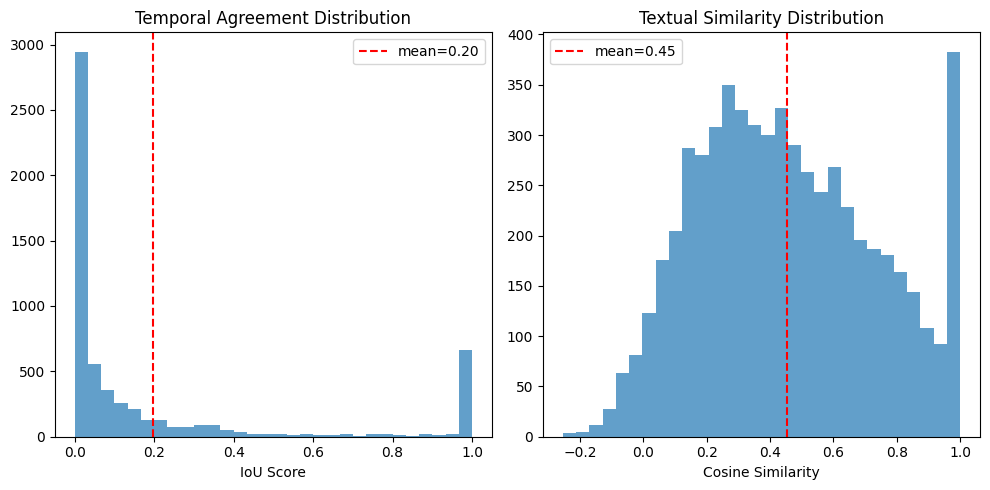

In [10]:
# Enhanced Visualization
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(stats['temporal_iou'], bins=30, alpha=0.7)
temporal_iou = np.mean(stats['temporal_iou'])
plt.axvline(x=temporal_iou, color='red', linestyle='--', label=f'mean={temporal_iou:4.2f}')
plt.title('Temporal Agreement Distribution')
plt.xlabel('IoU Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(stats['textual_sim'], bins=30, alpha=0.7)
textual_sim = np.mean(stats['textual_sim'])
plt.axvline(x=textual_sim, color='red', linestyle='--', label=f'mean={textual_sim:4.2f}')
plt.title('Textual Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.legend()

plt.tight_layout()
plt.show()

### (b) To what extent do the annotations rely on or deviate from keywords and textual descriptions in the audio’s metadata?

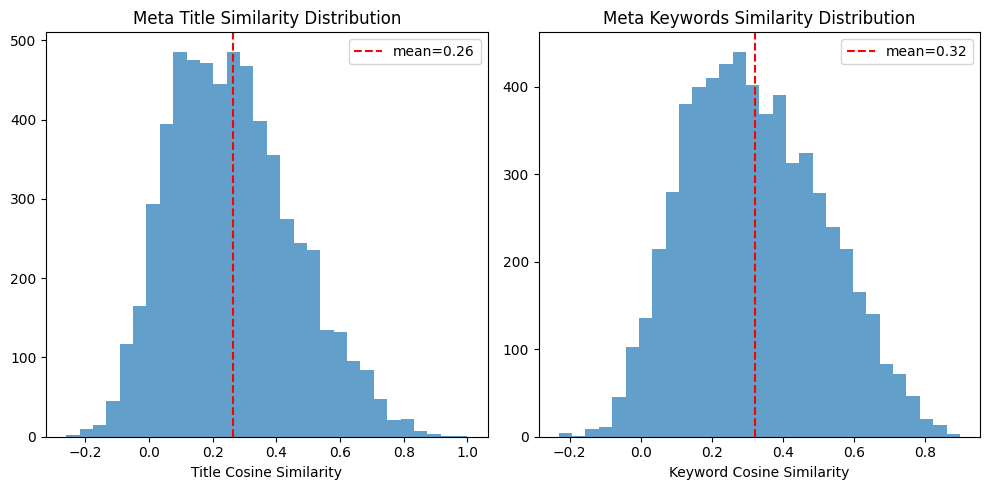

In [11]:
def metadata_alignment_analysis():
    
    # Get metadata indices for all annotated files
    meta_indices = metadata.reset_index().merge(annotations[['filename']].drop_duplicates(), on='filename').set_index('filename')['index']
    
    # Calculate similarities
    results = []
    for filename, group in annotations.groupby('filename'):
        if len(group) < 2:
            continue
        
        meta_idx = meta_indices[filename]
        meta_title_emb = title_embeddings[meta_idx].reshape(1, -1)
        meta_keywords_emb = keywords_embeddings[meta_idx].reshape(1, -1)
        annots_embs = annotations_embeddings[group.index]
        
        title_sims = cosine_similarity(meta_title_emb, annots_embs)[0]
        keywords_sims = cosine_similarity(meta_keywords_emb, annots_embs)[0]
        
        results.append({
            'filename': filename,
            'mean_title_sim': np.mean(title_sims),
            'mean_keywords_sim': np.mean(keywords_sims),
            'std_title_sim': np.std(title_sims),
            'std_keywords_sim': np.std(keywords_sims),
            'n_annotations': len(group)
        })
    
    alignment_stats = pd.DataFrame(results)
    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(alignment_stats['mean_title_sim'], bins=30, alpha=0.7)
    meta_title_sim = np.mean(alignment_stats['mean_title_sim'])
    plt.axvline(x=meta_title_sim, color='red', linestyle='--', label=f'mean={meta_title_sim:4.2f}')
    plt.title('Meta Title Similarity Distribution')
    plt.xlabel('Title Cosine Similarity')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(alignment_stats['mean_keywords_sim'], bins=30, alpha=0.7)
    meta_keywords_sim = np.mean(alignment_stats['mean_keywords_sim'])
    plt.axvline(x=meta_keywords_sim, color='red', linestyle='--', label=f'mean={meta_keywords_sim:4.2f}')
    plt.title('Meta Keywords Similarity Distribution')
    plt.xlabel('Keyword Cosine Similarity')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return alignment_stats

alignment_stats = metadata_alignment_analysis()

### (c) Was the temporal and text annotations done according to the task description?

In [12]:
# Basic Compliance Metrics
def calculate_compliance_metrics(annotations, metadata):
    total_annotations = len(annotations)
    files_with_annotations = annotations['filename'].nunique()
    avg_annotations_per_file = total_annotations / files_with_annotations
    
    enhanced_metrics = {
        'basic': {
            'total_annotations': total_annotations,
            'files_with_annotations': files_with_annotations,
            'avg_annotations_per_file': avg_annotations_per_file,
        },
        'enhanced': {
            'min_duration_check': annotations[
                (annotations['offset'] - annotations['onset']) >= 0.1
            ].shape[0] / total_annotations,
            'descriptive_text': annotations[
                annotations['text'].str.split().str.len() >= 3
            ].shape[0] / total_annotations
        }
    }
    
    return enhanced_metrics

# Calculate metrics
compliance_metrics = calculate_compliance_metrics(annotations, metadata)

In [13]:
# Print results
print("BASIC COMPLIANCE METRICS:")
print(f"{'Total annotations':<30}: {compliance_metrics['basic']['total_annotations']}")
print(f"{'Files with annotations':<30}: {compliance_metrics['basic']['files_with_annotations']}")
print(f"{'Avg annotations/file':<30}: {compliance_metrics['basic']['avg_annotations_per_file']:.1f}")

print("\nENHANCED COMPLIANCE METRICS:")
print(f"{'Annotations ≥100ms':<30}: {compliance_metrics['enhanced']['min_duration_check']:.1%}")
print(f"{'Descriptive text (≥3 words)':<30}: {compliance_metrics['enhanced']['descriptive_text']:.1%}\n")

BASIC COMPLIANCE METRICS:
Total annotations             : 35826
Files with annotations        : 9026
Avg annotations/file          : 4.0

ENHANCED COMPLIANCE METRICS:
Annotations ≥100ms            : 99.5%
Descriptive text (≥3 words)   : 93.4%



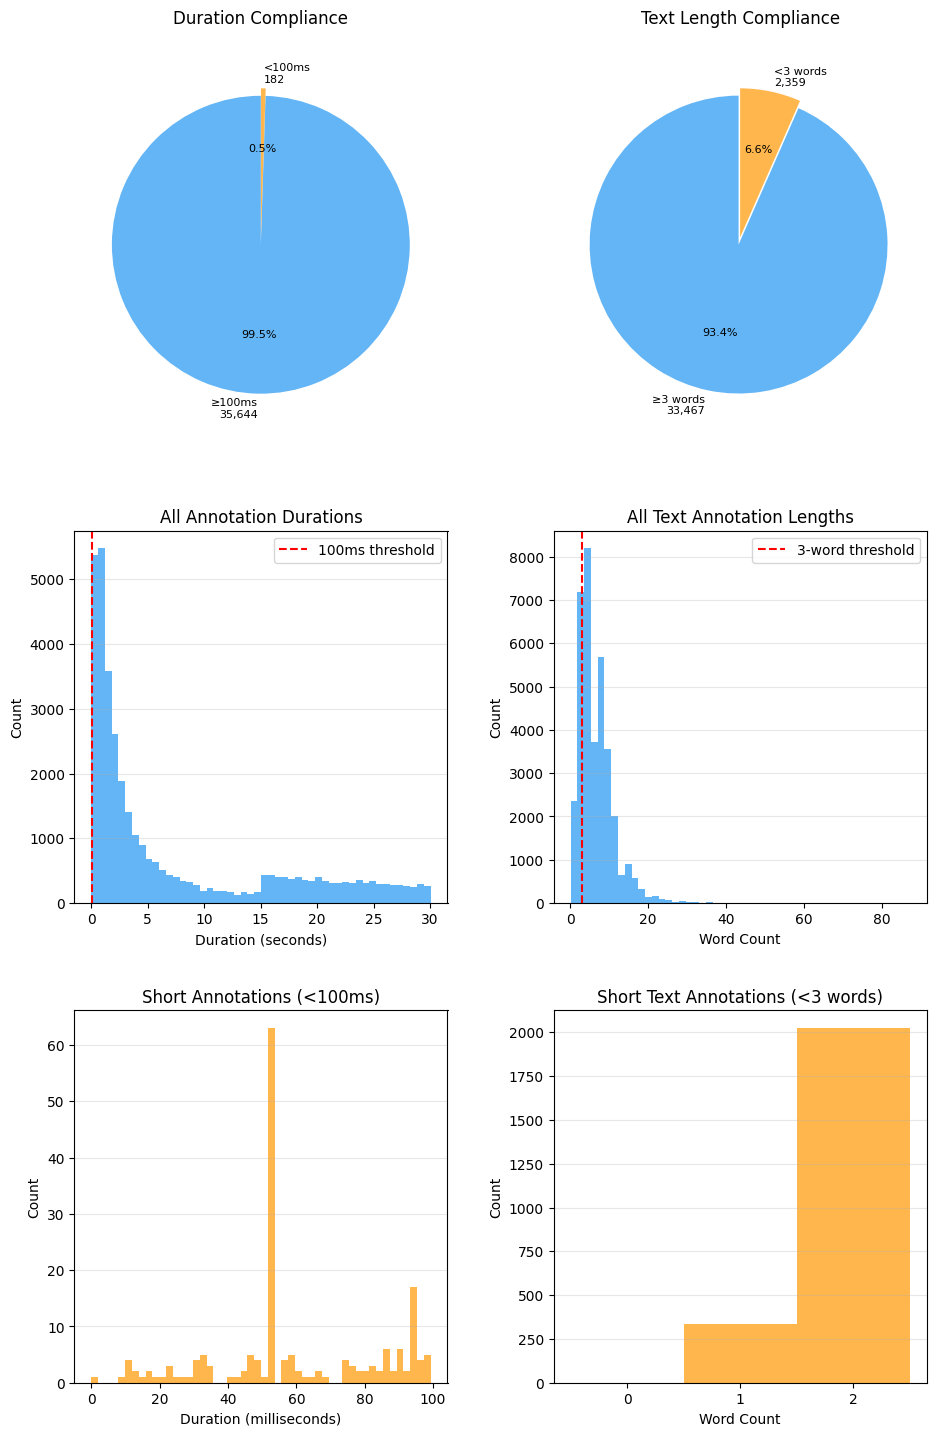

In [14]:
#TODO: Changed acc. to Moodle Template

# Enhanced Visualization
plt.figure(figsize=(10, 15))

# Pie Chart 1: Duration Compliance
plt.subplot(3, 2, 1)  # Row 1, Col 1
duration_compliance = (annotations['offset'] - annotations['onset']) >= 0.1
duration_counts = duration_compliance.value_counts()
plt.pie(duration_counts, 
        labels=[f'≥100ms\n{duration_counts[True]:,}', f'<100ms\n{duration_counts[False]:,}'],
        autopct='%1.1f%%',
        colors=['#2196F3', '#FF9800'],
        startangle=90,
        wedgeprops={'alpha': 0.7, 'linewidth': 1},
        explode=(0.05, 0),
        textprops={'fontsize': 8})
plt.title('Duration Compliance', pad=20)

# Pie Chart 2: Text Length Compliance
plt.subplot(3, 2, 2)  # Row 1, Col 2
text_compliance = annotations['text'].str.split().str.len() >= 3
text_counts = text_compliance.value_counts()
plt.pie(text_counts,
        labels=[f'≥3 words\n{text_counts[True]:,}', f'<3 words\n{text_counts[False]:,}'],
        autopct='%1.1f%%',
        colors=['#2196F3', '#FF9800'],
        startangle=90,
        wedgeprops={'alpha': 0.7, 'linewidth': 1},
        explode=(0.05, 0),
        textprops={'fontsize': 8})
plt.title('Text Length Compliance', pad=20)

# Histogram 1: All Durations
plt.subplot(3, 2, 3)  # Row 2, Col 1
durations = annotations['offset'] - annotations['onset']
plt.hist(durations, bins=50, color='#2196F3', alpha=0.7)
plt.title('All Annotation Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.axvline(x=0.1, color='red', linestyle='--', label='100ms threshold')
plt.legend()

# Histogram 2: All Text Lengths
plt.subplot(3, 2, 4)  # Row 2, Col 2
text_lengths = annotations['text'].str.split().str.len()
plt.hist(text_lengths, bins=50, color='#2196F3', alpha=0.7, align='left')
plt.title('All Text Annotation Lengths')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.axvline(x=3, color='red', linestyle='--', label='3-word threshold')
plt.legend()

# Histogram 3: Short Durations (<100ms)
plt.subplot(3, 2, 5)  # Row 3, Col 1
short_durations = annotations[annotations['offset'] - annotations['onset'] < 0.1]
durations_ms = (short_durations['offset'] - short_durations['onset']) * 1000
plt.hist(durations_ms, bins=50, color='#FF9800', alpha=0.7)
plt.title('Short Annotations (<100ms)')
plt.xlabel('Duration (milliseconds)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

# Histogram 4: Short Texts (<3 words)
plt.subplot(3, 2, 6)  # Row 3, Col 2
short_texts = annotations[annotations['text'].str.split().str.len() < 3]
text_lengths = short_texts['text'].str.split().str.len()
plt.hist(text_lengths, bins=[0,1,2,3], color='#FF9800', alpha=0.7, align='left')
plt.title('Short Text Annotations (<3 words)')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.xticks([0,1,2])
plt.grid(axis='y', alpha=0.3)

plt.tight_layout(pad=3.0)
plt.show()

## Task 2: Annotation Quality:

### (a) How precise are the temporal annotations?

In [15]:
# Temporal Precision Analysis
print("\n" + "="*80)
print("Temporal Annotation Precision Analysis")
print("="*80)

# Calculate IoU between all annotation pairs per file
temporal_stats = annotations.groupby('filename').apply(annotations_agreement).dropna()

# Filter files with at least 2 annotators
valid_files = temporal_stats[(temporal_stats['n_annotators'] >= 2)]
mean_iou = valid_files['temporal_iou'].mean()
median_iou = valid_files['temporal_iou'].median()

print(f"{'Mean Temporal IoU: ':<25}{mean_iou:5.2f}")
print(f"{'Median Temporal IoU: ':<25}{median_iou:5.2f}")
print(f"{'% of files with IoU>0.5: ':<25}{(valid_files['temporal_iou'] > 0.5).mean():5.2%}")


Temporal Annotation Precision Analysis
Mean Temporal IoU:        0.42
Median Temporal IoU:      0.21
% of files with IoU>0.5: 34.75%


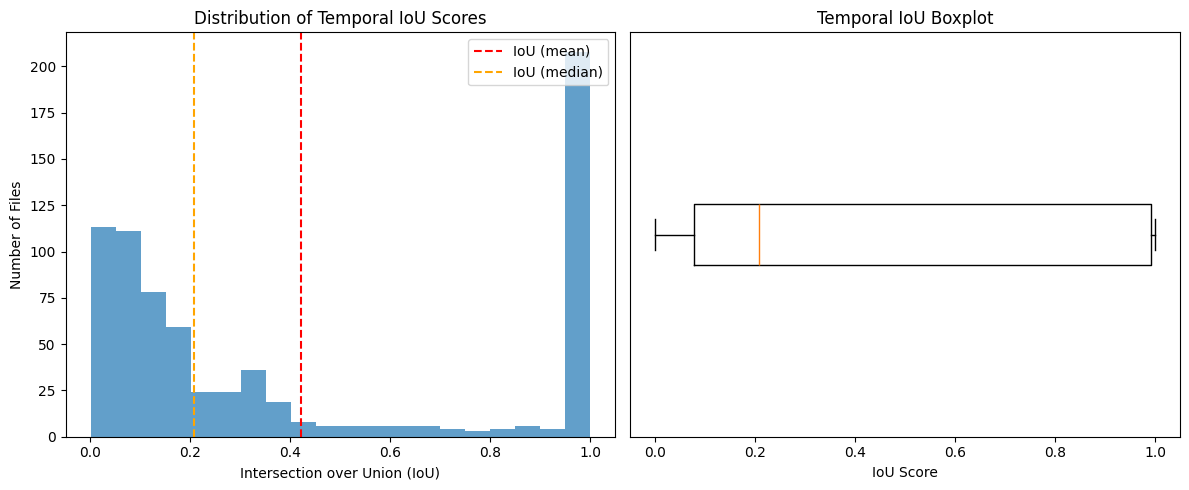

In [16]:
# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(valid_files['temporal_iou'], bins=20, alpha=0.7)
plt.axvline(x=mean_iou, color='red', linestyle='--', label='IoU (mean)')
plt.axvline(x=median_iou, color='orange', linestyle='--', label='IoU (median)')
plt.title('Distribution of Temporal IoU Scores')
plt.xlabel('Intersection over Union (IoU)')
plt.ylabel('Number of Files')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(valid_files['temporal_iou'], vert=False)
plt.title('Temporal IoU Boxplot')
plt.xlabel('IoU Score')
plt.yticks([])
plt.tight_layout()
plt.show()

In [17]:
# Textual Similarity Analysis
print("\n" + "="*80)
print("Textual Annotation Similarity Analysis")
print("="*80)

mean_text_sim = valid_files['textual_sim'].mean()
median_text_sim = valid_files['textual_sim'].median()

print(f"{'Mean Textual Similarity: ':<35}{mean_text_sim:5.2f}")
print(f"{'Median Textual Similarity: ':<35}{median_text_sim:5.2f}")
print(f"{'% of files with Similarity>0.7: ':<35}{(valid_files['textual_sim'] > 0.7).mean():5.2%}")


Textual Annotation Similarity Analysis
Mean Textual Similarity:            0.44
Median Textual Similarity:          0.42
% of files with Similarity>0.7:    13.95%


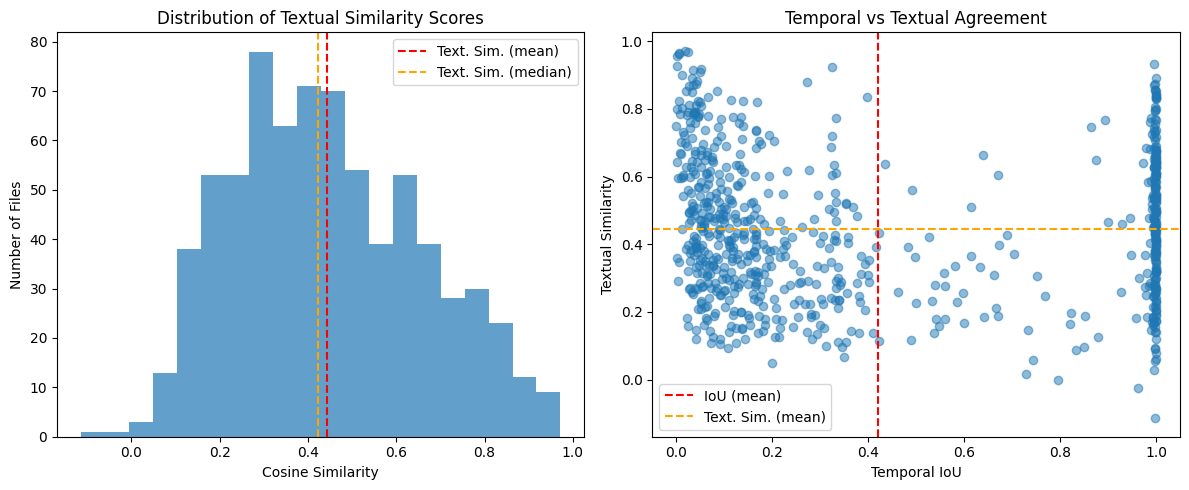

In [18]:
# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(valid_files['textual_sim'], bins=20, alpha=0.7)
plt.axvline(x=mean_text_sim, color='red', linestyle='--', label='Text. Sim. (mean)')
plt.axvline(x=median_text_sim, color='orange', linestyle='--', label='Text. Sim. (median)')
plt.title('Distribution of Textual Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Number of Files')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(valid_files['temporal_iou'], valid_files['textual_sim'], alpha=0.5)
plt.axvline(x=mean_iou, color='red', linestyle='--', label='IoU (mean)')
plt.axhline(y=mean_text_sim, color='orange', linestyle='--', label='Text. Sim. (mean)')
plt.title('Temporal vs Textual Agreement')
plt.xlabel('Temporal IoU')
plt.ylabel('Textual Similarity')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Annotation Quantity Analysis
print("\n" + "="*80)
print("Annotation Quantity Analysis")
print("="*80)

# Annotations per file
annotations_per_file = annotations.groupby('filename').size()
mean_annots = annotations_per_file.mean()
median_annots = annotations_per_file.median()

# Distinct sound events per file
distinct_events = annotations.groupby('filename')['text'].nunique()
mean_events = distinct_events.mean()
median_events = distinct_events.median()

print(f"{'Mean annotations per file: ':<35}{mean_annots:.1f}")
print(f"{'Median annotations per file: ':<35}{median_annots:.1f}")
print(f"{'Mean distinct events per file: ':<35}{mean_events:.1f}")
print(f"{'Median distinct events per file: ':<35}{median_events:.1f}")


Annotation Quantity Analysis
Mean annotations per file:         4.0
Median annotations per file:       2.0
Mean distinct events per file:     2.7
Median distinct events per file:   2.0


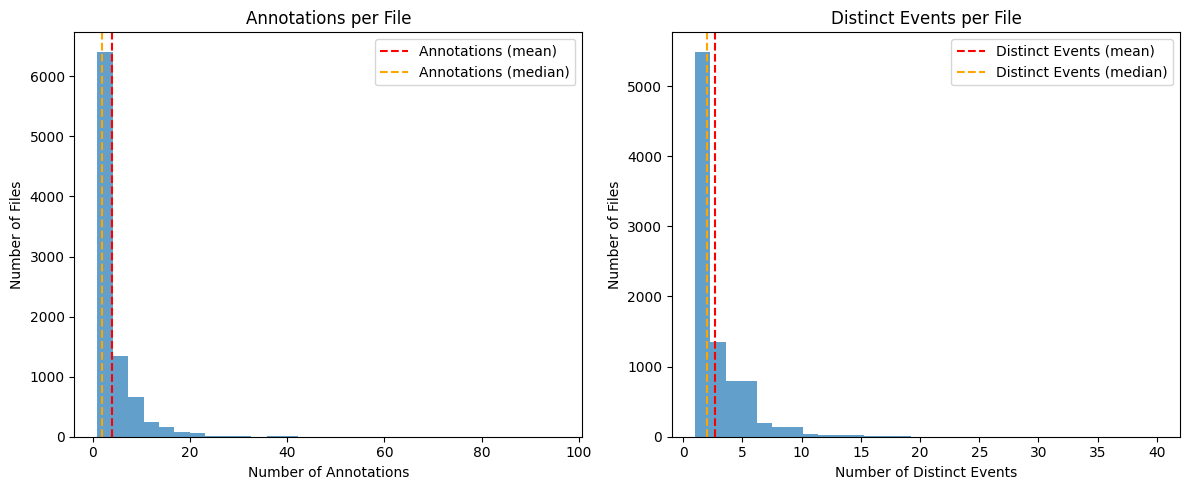

In [20]:
# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(annotations_per_file, bins=30, alpha=0.7)
plt.axvline(x=mean_annots, color='red', linestyle='--', label='Annotations (mean)')
plt.axvline(x=median_annots, color='orange', linestyle='--', label='Annotations (median)')
plt.title('Annotations per File')
plt.xlabel('Number of Annotations')
plt.ylabel('Number of Files')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(distinct_events, bins=30, alpha=0.7)
plt.axvline(x=mean_events, color='red', linestyle='--', label='Distinct Events (mean)')
plt.axvline(x=median_events, color='orange', linestyle='--', label='Distinct Events (median)')
plt.title('Distinct Events per File')
plt.xlabel('Number of Distinct Events')
plt.ylabel('Number of Files')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# Annotator Quality Analysis
print("\n" + "="*80)
print("Annotator Quality Analysis")
print("="*80)

# Calculate annotator-level metrics
annotator_stats = annotations.groupby('annotator').agg({
    'text': [
        ('count', 'size'),
        ('avg_words', lambda x: x.str.split().str.len().mean()),
        ('unique_terms', lambda x: len(set(' '.join(x).lower().split())))
    ],
    'onset': [('avg_duration', lambda x: (annotations.loc[x.index, 'offset'] - x).mean())]
})

# Flatten multi-index columns
annotator_stats.columns = ['_'.join(col) for col in annotator_stats.columns.values]

# Detect outliers using IQR
def flag_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return (series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))

annotator_stats['outlier_count'] = flag_outliers(annotator_stats['text_count'])
annotator_stats['outlier_words'] = flag_outliers(annotator_stats['text_avg_words'])
annotator_stats['outlier_duration'] = flag_outliers(annotator_stats['onset_avg_duration'])

# Print summary
print(f"Total annotators: {len(annotator_stats)}")
print(f"{'Annotators flagged for '}{'"low count": ':<25}{annotator_stats['outlier_count'].sum():2}")
print(f"{'Annotators flagged for '}{'"short texts": ':<25}{annotator_stats['outlier_words'].sum():2}")
print(f"{'Annotators flagged for '}{'"unusual durations": ':<25}{annotator_stats['outlier_duration'].sum():2}")


Annotator Quality Analysis
Total annotators: 330
Annotators flagged for "low count":              5
Annotators flagged for "short texts":           19
Annotators flagged for "unusual durations":     11


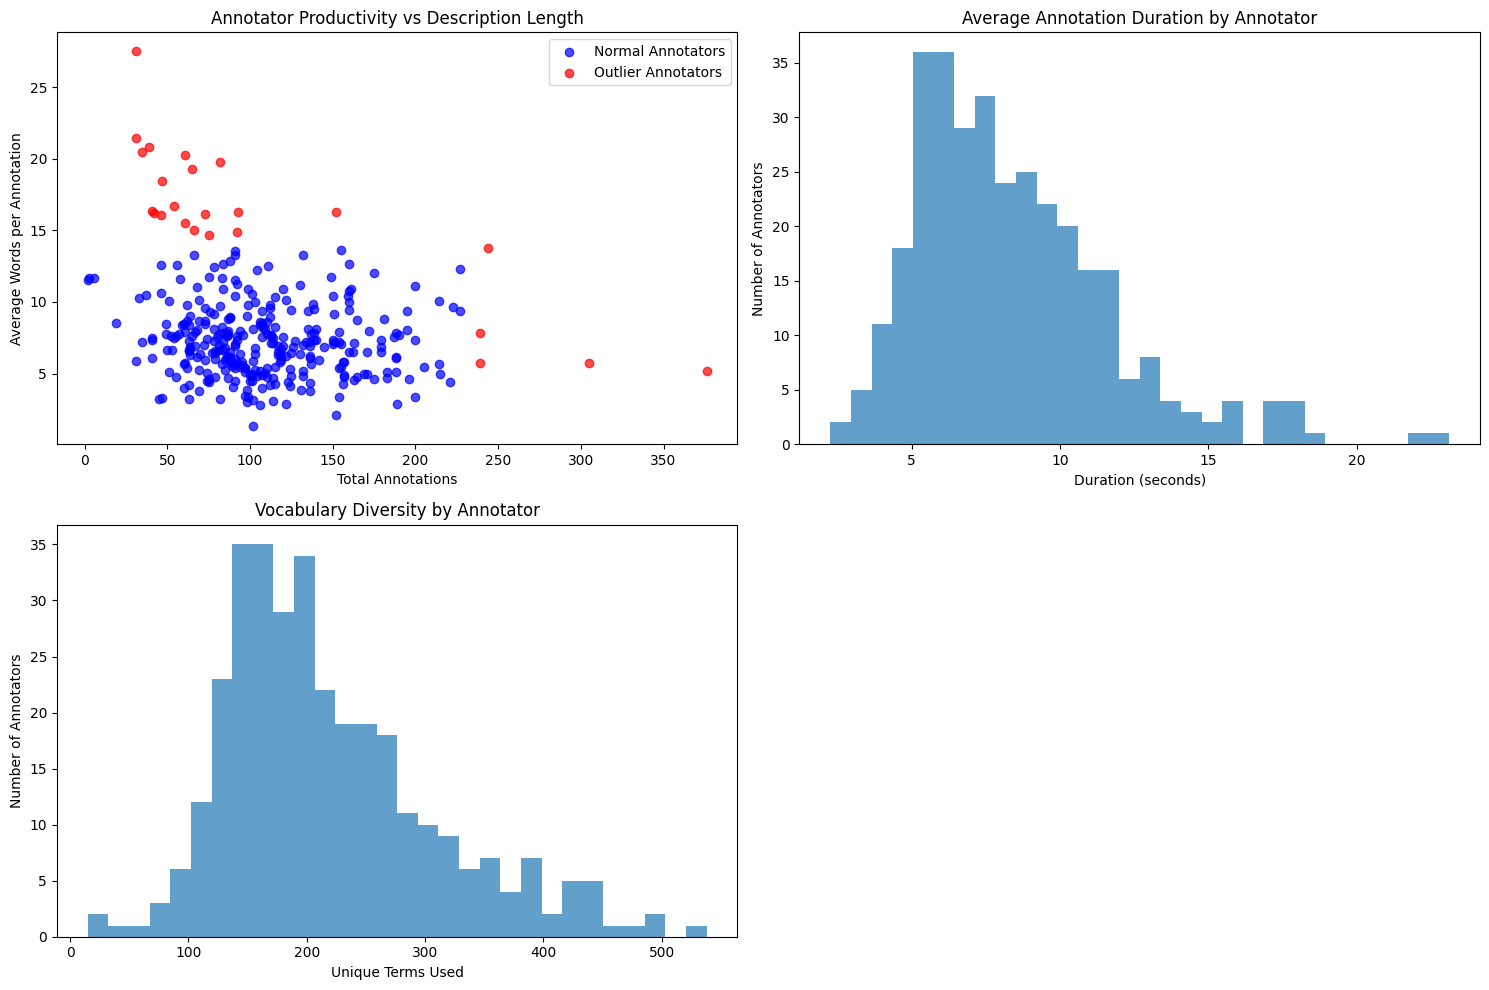

In [22]:
# Visualization
plt.figure(figsize=(15, 10))

# Create separate masks for different outlier types
outlier_mask = (annotator_stats['outlier_count'] | annotator_stats['outlier_words'])
normal_mask = ~outlier_mask

plt.subplot(2, 2, 1)
scatter1 = plt.scatter(annotator_stats.loc[normal_mask, 'text_count'], 
                      annotator_stats.loc[normal_mask, 'text_avg_words'], 
                      c='blue', alpha=0.7, label='Normal Annotators')

scatter2 = plt.scatter(annotator_stats.loc[outlier_mask, 'text_count'], 
                      annotator_stats.loc[outlier_mask, 'text_avg_words'], 
                      c='red', alpha=0.7, label='Outlier Annotators')

plt.title('Annotator Productivity vs Description Length')
plt.xlabel('Total Annotations')
plt.ylabel('Average Words per Annotation')
plt.legend(handles=[scatter1, scatter2], loc='upper right')


plt.subplot(2, 2, 2)
plt.hist(annotator_stats['onset_avg_duration'], bins=30, alpha=0.7)
plt.title('Average Annotation Duration by Annotator')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Annotators')

plt.subplot(2, 2, 3)
plt.hist(annotator_stats['text_unique_terms'], bins=30, alpha=0.7)
plt.title('Vocabulary Diversity by Annotator')
plt.xlabel('Unique Terms Used')
plt.ylabel('Number of Annotators')

plt.tight_layout()
plt.show()

In [23]:
# Proposed quality filter
def quality_filter(df, 
                  min_words=3, 
                  min_duration=0.1, 
                  max_duration=30,
                  max_annotators=5):
    """Filter annotations based on quality criteria"""
    # Basic content requirements
    mask = (
        (df['text'].str.split().str.len() >= min_words) &
        ((df['offset'] - df['onset']) >= min_duration) &
        ((df['offset'] - df['onset']) <= max_duration))
    
    # Annotator quality requirements
    good_annotators = annotator_stats[
        ~(annotator_stats['outlier_count'] | 
          annotator_stats['outlier_words'] |
          annotator_stats['outlier_duration'])
    ].index
    
    mask = mask & df['annotator'].isin(good_annotators)
    
    # Limit annotations per file
    file_counts = df.groupby('filename').cumcount()
    mask = mask & (file_counts < max_annotators)
    
    return df[mask]

# Apply filter and show impact
filtered = quality_filter(annotations)
removed_pct = (len(annotations) - len(filtered)) / len(annotations)

print(f"\nProposed quality filter would remove {removed_pct:.1%} of annotations")
print("Filter criteria:")
print("- Minimum 3 words per annotation")
print("- Duration between 0.1s and 30s")
print("- Excluding outlier annotators")
print("- Maximum 10 annotations per file")


Proposed quality filter would remove 38.8% of annotations
Filter criteria:
- Minimum 3 words per annotation
- Duration between 0.1s and 30s
- Excluding outlier annotators
- Maximum 10 annotations per file


## Task 3: Audio Features

In [24]:
# Analyze and cluster audio features
def print_audio_features(sample_files):
    # Feature exploration
    sample_file = metadata.loc[0, 'filename'].replace("mp3", "npz")
    sample_features = np.load(os.path.join("audio_features", sample_file))

    print("="*80)
    print("Audio Feature Analysis")
    print("="*80)
    print("\nAvailable Audio Features:")
    for k, v in sample_features.items():
        print(f"- {k:<20} {v.shape}")
    
    # Feature selection
    selected_features = ['embeddings', 'melspectrogram', 'mfcc']
    print(f"\nSelected Features: {','.join(selected_features)}")
    
    # Process multiple files
    file_sample = metadata['filename'].sample(sample_files)
    print(f"\nProcessing {len(file_sample)} random audio files...")

    return file_sample, selected_features
    
# Execute the analysis
file_sample, selected_features = print_audio_features(sample_files=100)

Audio Feature Analysis

Available Audio Features:
- embeddings           (233, 768)
- melspectrogram       (233, 64)
- mfcc                 (233, 32)
- mfcc_delta           (233, 32)
- mfcc_delta2          (233, 32)
- flatness             (233, 1)
- centroid             (233, 1)
- flux                 (233, 1)
- energy               (233, 1)
- power                (233, 1)
- bandwidth            (233, 1)
- contrast             (233, 7)
- zerocrossingrate     (233, 1)

Selected Features: embeddings,melspectrogram,mfcc

Processing 100 random audio files...


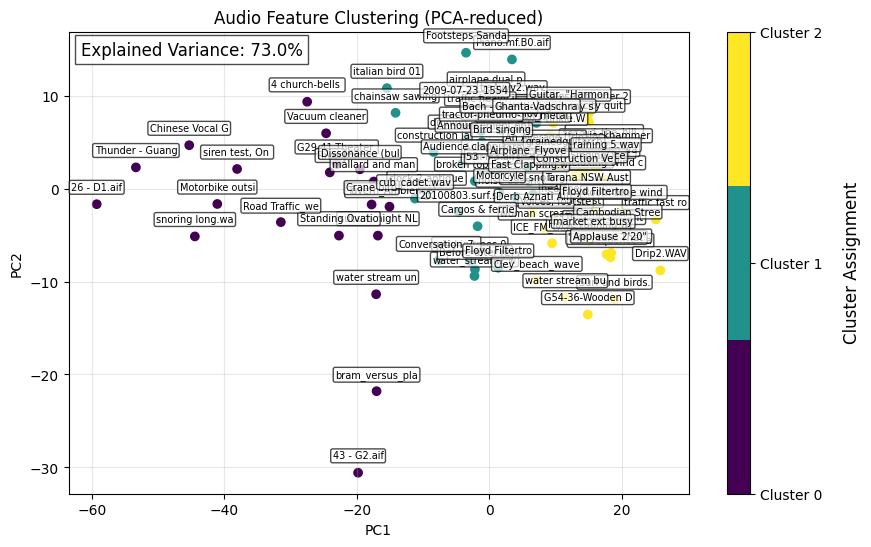

In [25]:
# Visualize audio feature clustering
def visualize_audio_features(file_sample, selected_features):
    
    # Process files and extract features
    all_features = []
    for filename in file_sample:
        feature_file = filename.replace("mp3", "npz")
        features = np.load(os.path.join("audio_features", feature_file))
        combined = np.hstack([features[k] for k in selected_features])
        all_features.append(combined.mean(axis=0))
    
    all_features = np.array(all_features)
    
    # Dimensionality reduction
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(all_features)
    
    # Clustering
    n_clusters = len(selected_features)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(all_features)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    cmap = plt.cm.get_cmap('viridis', n_clusters)
    scatter = plt.scatter(reduced[:,0], reduced[:,1], c=clusters, cmap=cmap)
    plt.title('Audio Feature Clustering (PCA-reduced)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(alpha=0.3)

    # Add colorbar
    cbar = plt.colorbar(scatter, ticks=range(n_clusters))
    cbar.set_label('Cluster Assignment', fontsize=12, labelpad=15)
    cbar.set_ticklabels(['Cluster 0', 'Cluster 1', 'Cluster 2'])
    
    # Add sample labels
    for i, (x, y) in enumerate(reduced):
        plt.annotate(
            metadata.loc[i, 'title'][:15],
            (x, y),
            textcoords="offset points",
            xytext=(0,10),
            fontsize=7,
            ha='center',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7)
        )
    
    # Add explained variance ratio
    plt.text(0.02, 0.98, 
             f"Explained Variance: {pca.explained_variance_ratio_.sum():.1%}",
             transform=plt.gca().transAxes,
             fontsize=12,
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.7))
    plt.show()

    # Get the indices of the annotations we processed
    processed_indices = annotations[annotations['filename'].isin(file_sample)].index
    
    return {
        'features': all_features,
        'reduced': reduced,
        'clusters': clusters,
        'processed_indices': processed_indices,
        'file_sample': file_sample
    }

# Execute the analysis
audio_results = visualize_audio_features(file_sample, selected_features)

## Task 4: Text Features

In [26]:
# Analyze and cluster text features
def print_text_features(n_clusters):
    
    print("="*80)
    print("Text Feature Analysis")
    print("="*80)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    text_clusters = kmeans.fit_predict(annotations_embeddings)
    
    # Extract cluster terms
    cluster_terms = []
    for i in range(n_clusters):
        cluster_mask = (text_clusters == i)
        cluster_texts = annotations.loc[cluster_mask, 'text']
        all_words = ' '.join(cluster_texts).lower().split()
        top_words = pd.Series(all_words).value_counts().head(5).index.tolist()
        cluster_terms.append(top_words)

    print("\nText Cluster Topics:")
    for i, terms in enumerate(cluster_terms):
        print(f"Cluster {i}: {', '.join(terms)}")

    return text_clusters, cluster_terms

# Execute the analysis
text_clusters, cluster_terms = print_text_features(n_clusters=10)

Text Feature Analysis

Text Cluster Topics:
Cluster 0: a, the, in, sound, of
Cluster 1: dog, a, barking, in, the
Cluster 2: a, sound, of, the, and
Cluster 3: a, bird, chirping, in, birds
Cluster 4: a, bell, ringing, in, sound
Cluster 5: a, in, the, loudly, cat
Cluster 6: a, the, in, of, sound
Cluster 7: a, the, in, and, of
Cluster 8: a, the, water, of, in
Cluster 9: a, of, sound, and, in


In [27]:
# Calculate and print cluster purity metrics
def cluster_purity(text_clusters):

    dog_mask = annotations['text'].str.contains('dog|bark|woof', case=False)
    cat_mask = annotations['text'].str.contains('cat|meow|purr', case=False)
    
    def purity(mask, clusters):
        cluster_counts = pd.Series(clusters[mask]).value_counts()
        return cluster_counts.max() / mask.sum() if len(cluster_counts) > 0 else 0
    
    dog_purity = purity(dog_mask, text_clusters)
    cat_purity = purity(cat_mask, text_clusters)

    print(f"\nFound {dog_mask.sum()} dog-related annotations")
    print(f"Found {cat_mask.sum()} cat-related annotations")
    print(f"\nDog annotation cluster purity: {dog_purity:.1%}")
    print(f"Cat annotation cluster purity: {cat_purity:.1%}")
    
    return dog_mask, cat_mask

# Calculate cluster purity
dog_mask, cat_mask = cluster_purity(text_clusters)


Found 1653 dog-related annotations
Found 919 cat-related annotations

Dog annotation cluster purity: 85.6%
Cat annotation cluster purity: 56.0%


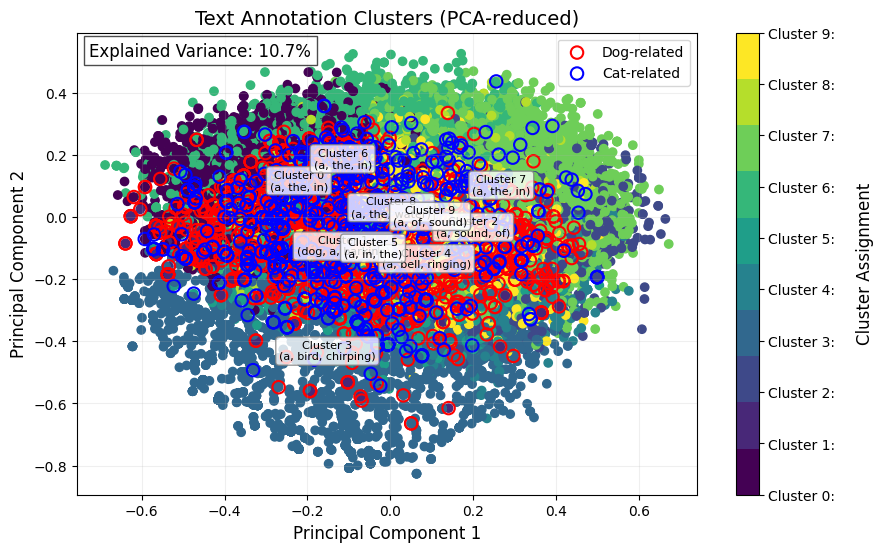

In [28]:
# Visualize text feature clusters
def visualize_text_clusters(text_results):
    
    # Extract data from results dictionary
    text_clusters = text_results['text_clusters']
    cluster_terms = text_results['cluster_terms']
    dog_mask = text_results['dog_mask']
    cat_mask = text_results['cat_mask']
    n_clusters = len(np.unique(text_clusters))
    
    # Dimensionality reduction 
    pca = PCA(n_components=2)
    reduced_text = pca.fit_transform(annotations_embeddings)

    # Plot clusters
    plt.figure(figsize=(10, 6))
    cmap = plt.cm.get_cmap('viridis', n_clusters)
    scatter = plt.scatter(reduced_text[:,0], reduced_text[:,1], c=text_clusters, cmap=cmap)

    # Add colorbar
    cbar = plt.colorbar(scatter, ticks=range(n_clusters))
    cbar.set_label('Cluster Assignment', fontsize=12, labelpad=15)
    cbar.set_ticklabels([f'Cluster {i}:' for i in range(n_clusters)])
    
    # Highlight special categories
    plt.scatter(reduced_text[dog_mask, 0], reduced_text[dog_mask, 1],
               edgecolor='red', facecolor='none', s=80,
               linewidth=1.5, label='Dog-related')
    plt.scatter(reduced_text[cat_mask, 0], reduced_text[cat_mask, 1],
               edgecolor='blue', facecolor='none', s=80,
               linewidth=1.5, label='Cat-related')

    # Add cluster labels
    for i in range(n_clusters):
        cluster_points = reduced_text[text_clusters == i]
        if len(cluster_points) > 0:
            centroid = cluster_points.mean(axis=0)
            plt.annotate(f"Cluster {i}\n({', '.join(cluster_terms[i][:3])})",
                        xy=centroid, xytext=(0,0),
                        textcoords="offset points",
                        ha='center', va='center',
                        fontsize=8, bbox=dict(boxstyle="round,pad=0.3",
                                             fc="white", ec="gray", alpha=0.8))

    
    # Formatting
    plt.title('Text Annotation Clusters (PCA-reduced)', fontsize=14)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.grid(alpha=0.2)
    plt.legend(loc='upper right')
    
    # Add explained variance
    plt.text(0.02, 0.98, 
             f"Explained Variance: {pca.explained_variance_ratio_.sum():.1%}",
             transform=plt.gca().transAxes,
             fontsize=12,
             verticalalignment='top',
             bbox=dict(facecolor='white', alpha=0.7))
    
    plt.show()

# Create results dictionary
text_results = {
    'text_clusters': text_clusters,
    'cluster_terms': cluster_terms,
    'dog_mask': dog_mask,
    'cat_mask': cat_mask
}

# Visualize results
visualize_text_clusters(text_results)

## Task 5: Conclusions

Final Conclusions:

DATASET_USEFULNESS:

BIASES:

RECOMMENDATIONS:
